# Bootstrap

In this notebook I will cover the bootstrap method. A toy regression dataset will be created using the make_regression function available through scikit-learn.

In [1]:
# imports
from typing import Tuple, Dict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
def make_bootstraps(data: np.array, n_bootstraps: int=100) -> Dict[str, Dict[str, np.array]]:
    """
    Function to generate bootstrapped samples
    
    Inputs:
        data         -> array of input data
        n_bootstraps -> integer number of bootstraps to produce
        
    Outputs:
        {'boot_n': {'boot': np.array, 'test': np.array}} -> dictionary of dictionaries containing 
                                                            the bootstrap samples & out-of-bag test sets
    """
    
    # initialize output dictionary, unique value count, sample size, & list of indices
    dc       = {}
    n_unival = 0
    sample_size = data.shape[0]
    idx = [i for i in range(sample_size)]
    # loop through the required number of bootstraps
    for b in range(n_bootstraps):
        # obtain boostrap samples with replacement
        sidx   = np.random.choice(idx,replace=True,size=sample_size)
        b_samp = data[sidx,:]
        # compute number of unique values contained in the bootstrap sample
        n_unival += len(set(sidx))
        # obtain out-of-bag samples for the current b
        oob_idx = list(set(idx) - set(sidx))
        t_samp = np.array([])
        if oob_idx:
            t_samp = data[oob_idx,:]
        # store results
        dc['boot_'+str(b)] = {'boot':b_samp,'test':t_samp}
    # state the mean number of unique values in the bootstraps
    print('Mean number of unique values in each bootstrap: {:.2f}'.format(n_unival/n_bootstraps))
    # return the bootstrap results
    return(dc)

def prediction_error_by_training_size(train: np.array, 
                                      test: np.array, 
                                      train_sizes: list, 
                                      iters: int=10) -> Tuple[list, list]:
    """
    Function to determine the relationship between model performance & training size
    
    Inputs:
        train       -> array containing training data
        test        -> array containing test data
        train_sizes -> list containing the integer number of samples to be used in the training set
        iters       -> number of repetitions to be done for each training size
        
    Outputs:
        (list,list) -> a tuple of two lists containing the average MAE and MSE errors for each train_sizes element
    """
    # initialize model & output lists
    lr    = LinearRegression()
    maes  = []
    mses  = []
    # get list of row indexes
    idx = [i for i in range(train.shape[0])]
    # loop over each training size
    for ts in train_sizes:
        # initialize error metrics
        mae = 0
        mse = 0
        # for each training size, repeat the calculation iters times
        for _ in range(iters):
            # obtain training samples without replacement
            sidx     = np.random.choice(idx,replace=False,size=ts)
            trainset = np.copy(train[sidx,:])
            # fit a linear regression model to the training set
            lr.fit(trainset[:,0].reshape(-1,1),trainset[:,1].reshape(-1,1))
            # generate predictions & calculate error metrics
            yp  = lr.predict(test[:,0].reshape(-1,1))
            mae += mean_absolute_error(test[:,1],yp)
            mse += mean_squared_error(test[:,1],yp) 
        # store the mean error metrics over all repetitions
        maes.append(mae/iters)
        mses.append(mse/iters)
    # return error metrics
    return(maes,mses)

### Synthetic Regression Dataset

Let's look at a synthetic regression dataset using the scikit-learn API. These data will consist of 5000 samples with 1 input, and 1 output feature. The noise on the output variable follows a gaussian with a standard-deviation of 25.0. The y-intercept is set as 1.0.

In [3]:
# build a synthetic regression dataset
x,y,coef = make_regression(n_samples=5000,n_features=1,n_targets=1,coef=True,noise=5.0,bias=1.0,random_state=42)

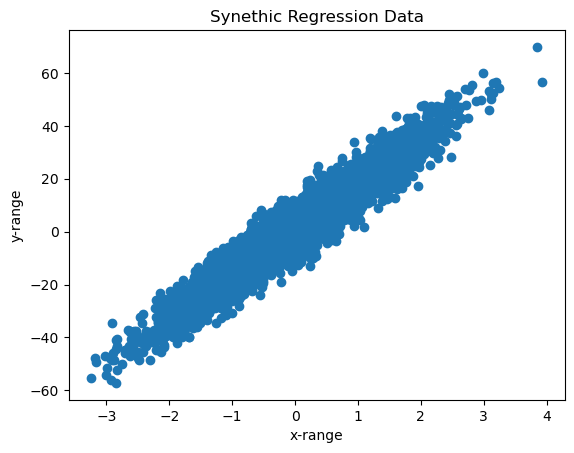

In [4]:
# plot regression data
plt.scatter(x,y)
plt.xlabel('x-range')
plt.ylabel('y-range')
plt.title('Synethic Regression Data')
plt.show()

### Training Size vs Performance

As a first step, let's take a look at how the performance of the model is affected by the training set size of unique data points?

In [5]:
# extract out a small test set to measure performance
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.1, random_state=42)

In [6]:
# define a set of training set sizes to choose from
train_size = [10,20,40,60,80,100,200,300,400]

In [7]:
# package the data
train = np.concatenate((xtrain,ytrain.reshape(-1,1)),axis=1)
test  = np.concatenate((xtest,ytest.reshape(-1,1)),axis=1)

In [8]:
# for each training set size, fit a model and calculate the error
maes,mses = prediction_error_by_training_size(train,test,train_size)

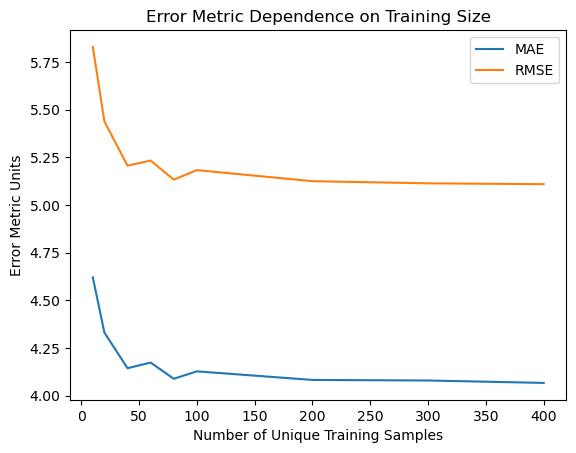

In [9]:
# plot the error curves
plt.plot(train_size,maes)
plt.plot(train_size,np.sqrt(mses))
plt.title('Error Metric Dependence on Training Size')
plt.xlabel('Number of Unique Training Samples')
plt.ylabel('Error Metric Units')
plt.legend(['MAE','RMSE'])
plt.show()

The plot above indicates that the linear regression model reaches an optimium with a training set containing approximately 75 unique samples. It's important to keep this in mind during the application of the bootstrap method.

### Bootstrap Analysis

Let's now proceed with carrying out a bootstrap analysis of these data:

In [10]:
# package the data
data = np.concatenate((x,y.reshape(-1,1)),axis=1)

In [11]:
# generate bootstrap samples
dcBoot = make_bootstraps(data)

Mean number of unique values in each bootstrap: 3157.00


The number of unique values per bootstrap is significantly higher than the limit of ~75 determined earlier. We can therefore determine that bias will not be a problem during this analysis.

Next, let's iterate through each bootstrap sample and compute some interesting statistics:

In [12]:
# initialize storage variables & model
coefs = np.array([])
intrs = np.array([])
maes  = np.array([])
mses  = np.array([])
lr    = LinearRegression()
# loop through each bootstrap sample
for b in dcBoot:
    # fit a linear regression model to the current sample
    lr.fit(dcBoot[b]['boot'][:,0].reshape(-1, 1),dcBoot[b]['boot'][:,1].reshape(-1, 1))
    # store model parameters
    coefs = np.concatenate((coefs,lr.coef_.flatten()))
    intrs = np.concatenate((intrs,lr.intercept_.flatten()))
    # compute the predictions on the out-of-bag test set & compute metrics
    if dcBoot[b]['test'].size:
        yp  = lr.predict(dcBoot[b]['test'][:,0].reshape(-1, 1))
        mae = mean_absolute_error(dcBoot[b]['test'][:,1],yp)
        mse = mean_squared_error(dcBoot[b]['test'][:,1],yp)   
        # store the error metrics
        maes = np.concatenate((maes,mae.flatten()))
        mses = np.concatenate((mses,mse.flatten()))

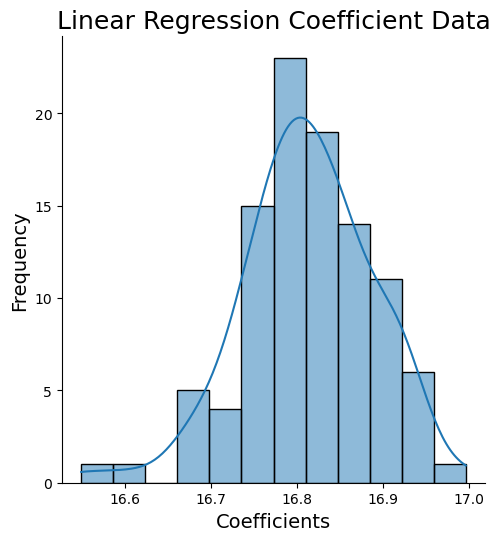

In [13]:
# plot histogram of regression coefficients
sns.displot(coefs, kde=True)
plt.title('Linear Regression Coefficient Data', fontsize=18)
plt.xlabel('Coefficients', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

In [14]:
# compute statistics on model coefficient
print('Expected value: {:.2f}'.format(np.mean(coefs)))
print('Estimate Standard Error: {:.2f}'.format(np.std(coefs)/np.sqrt(coefs.shape[0])))
print('99% Confidence Interval for regression coefficient: {0:.2f} - {1:.2f}'.format(np.percentile(coefs,0.5),
                                                                                     np.percentile(coefs,99.5)))

Expected value: 16.81
Estimate Standard Error: 0.01
99% Confidence Interval for regression coefficient: 16.58 - 16.97


In [15]:
# what is the true regression coefficient?
print('True regression coefficient: {:.2f}'.format(coef))

True regression coefficient: 16.82


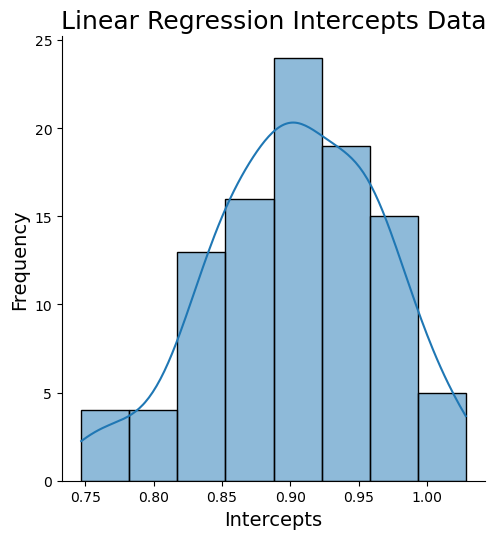

In [16]:
# plot histogram of regression intercepts
sns.displot(intrs, kde=True)
plt.title('Linear Regression Intercepts Data', fontsize=18)
plt.xlabel('Intercepts', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

In [17]:
# compute statistics on model intercept
print('Expected value: {:.2f}'.format(np.mean(intrs)))
print('Estimate Standard Error: {:.2f}'.format(np.std(intrs)/np.sqrt(intrs.shape[0])))
print('99% Confidence Interval for regression intercept: {0:.2f} - {1:.2f}'.format(np.percentile(intrs,0.5),
                                                                                   np.percentile(intrs,99.5)))

Expected value: 0.90
Estimate Standard Error: 0.01
99% Confidence Interval for regression intercept: 0.75 - 1.03


We can see that the true regression model parameters (16.82,1.0) are nicely contained within the 99% confidence intervals calculated above. The width of the confidence intervals also gives us a sense for how precise the model parameter values are, given by the optimisation procedure.

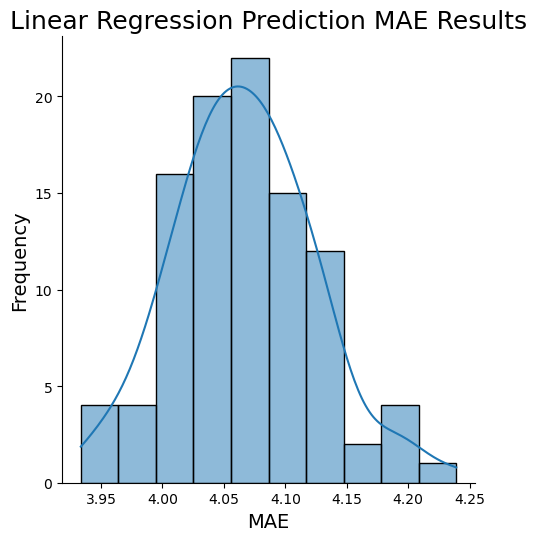

In [18]:
# plot histogram of mae on predictions
sns.displot(maes, kde=True)
plt.title('Linear Regression Prediction MAE Results', fontsize=18)
plt.xlabel('MAE', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

In [19]:
# compute statistics on MAE results
print('Expected value: {:.2f}'.format(np.mean(maes)))
print('Estimate Standard Error: {:.2f}'.format(np.std(maes)/np.sqrt(maes.shape[0])))
print('99% Confidence Interval for Prediction MAE results: {0:.2f} - {1:.2f}'.format(np.percentile(maes,0.5),
                                                                                     np.percentile(maes,99.5)))

Expected value: 4.07
Estimate Standard Error: 0.01
99% Confidence Interval for Prediction MAE results: 3.94 - 4.22


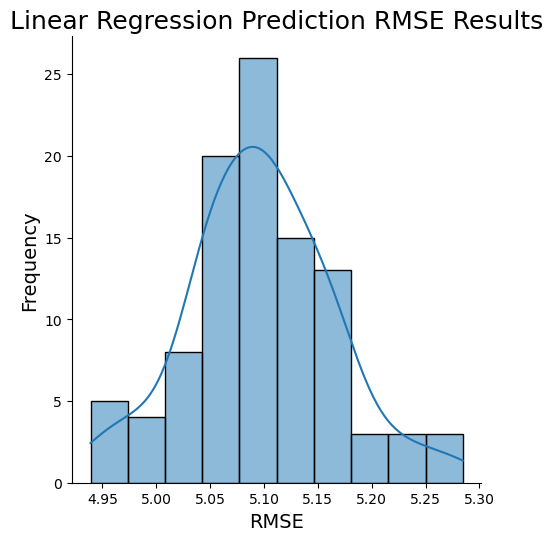

In [20]:
# plot histogram of rmse on predictions
sns.displot(np.sqrt(mses), kde=True)
plt.title('Linear Regression Prediction RMSE Results', fontsize=18)
plt.xlabel('RMSE', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

In [21]:
# compute statistics on RMSE results
rmse = np.sqrt(mses)
print('Expected value: {:.2f}'.format(np.mean(rmse)))
print('Estimate Standard Error: {:.2f}'.format(np.std(rmse)/np.sqrt(rmse.shape[0])))
print('99% Confidence Interval for Prediction RMSE results: {0:.2f} - {1:.2f}'.format(np.percentile(rmse,0.5),
                                                                                      np.percentile(rmse,99.5)))

Expected value: 5.10
Estimate Standard Error: 0.01
99% Confidence Interval for Prediction RMSE results: 4.94 - 5.28


Using the results of the bootstrap analysis permits us to determine confidence intervals for prediction error metrics of our choice. These results indicate the level of spread in the prediction error we can expect when using linear regression on our dataset. Note that the input noise level falls within the 99% CI for the RMSE.

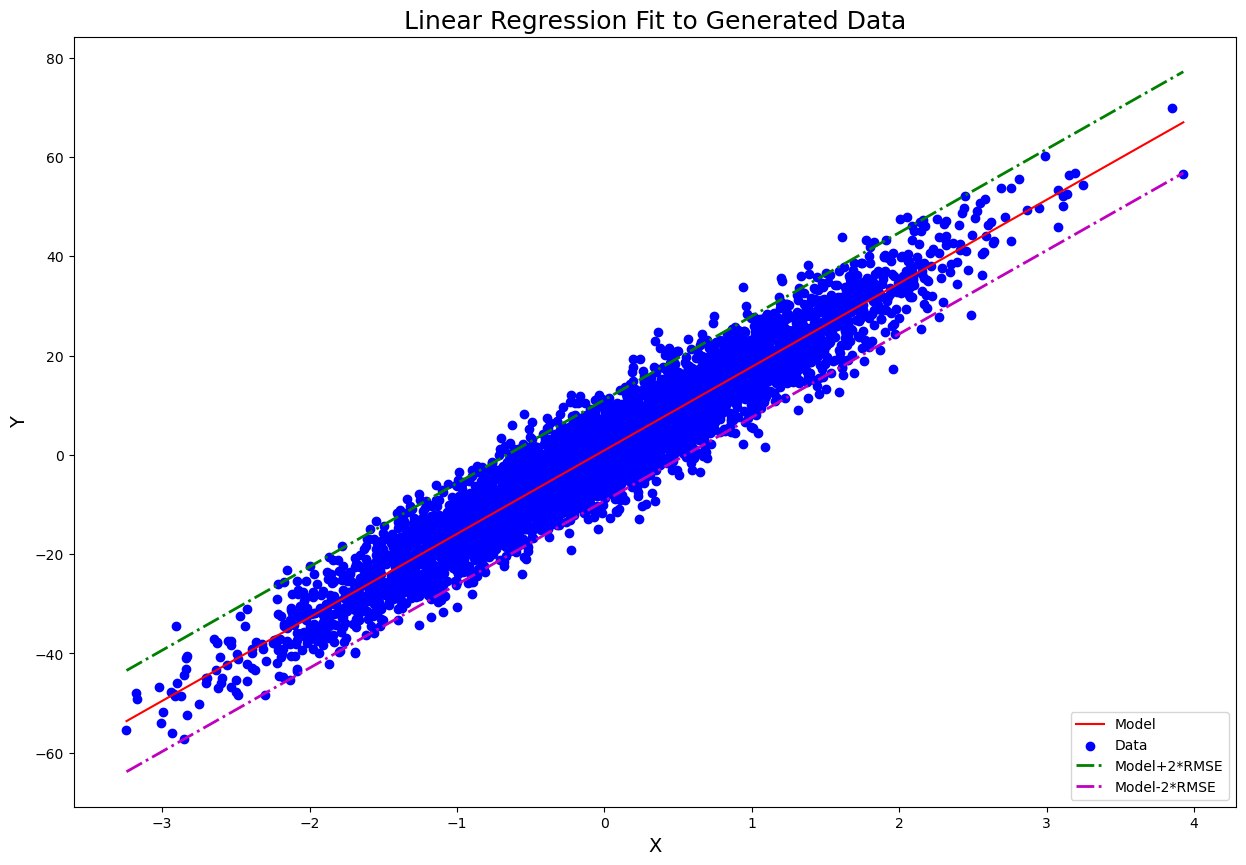

In [23]:
# plot the model against the dataset
xp = np.linspace(min(x),max(x),100)
plt.figure(figsize=(15,10))
plt.plot(xp,np.mean(coef)*xp+np.mean(intrs),color='r')
plt.scatter(x=data[:,0],y=data[:,1],color='b')
plt.plot(xp,np.mean(coef)*xp+np.mean(intrs)+2*np.mean(np.sqrt(mses)),'-.g',linewidth=2)
plt.plot(xp,np.mean(coef)*xp+np.mean(intrs)-2*np.mean(np.sqrt(mses)),'-.m',linewidth=2)
plt.title('Linear Regression Fit to Generated Data', fontsize=18)
plt.xlabel('X', fontsize=14)
plt.ylabel('Y', fontsize=14)
plt.legend(['Model','Data','Model+2*RMSE','Model-2*RMSE'],loc='lower right')
plt.show()